# Main

This jupyter notebook aims at giving a `craftai.pandas` use case to the user, introducing the various concepts and showcasing typical examples.

The work is based on the dataset `yellow_pickups.csv` located in the directory _data/_. (It is possible to regenerate this dataset by using the notebook `Preprocessing.ipynb`.)

`yellow_pickups.csv` has been extracted from the data available on the ___NYC Taxi and Limousine Commission (LTC)___ [webpage](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

__Goals__:
- The user is a NYC taxi driver who wants to know in the next hours where to drive to maximize their chances to find a client and maximize their fare amount.
- The user is a taxi company who wants to set up shop in a location near New York City, without any prior knowledge of taxi demand in the area.

In [1]:
import craft_ai.pandas
from craft_ai.pandas import MISSING_VALUE, OPTIONAL_VALUE
import copy
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
from contextlib import contextmanager
import time
from dotenv import load_dotenv
load_dotenv()

FIGSIZE = (25, 6)
FONT = {"family": "sans-serif", "weight": "normal", "size": 16}

@contextmanager    
def timer():
    start = time.perf_counter()
    elapser = lambda: time.perf_counter() - start
    yield lambda: elapser()
    end = time.perf_counter()
    elapser = lambda: end-start

Python-dotenv could not parse statement starting at line 1


## 1. `Yellow` dataset handling

### 1.1. Load `yellow` Dataset

`yellow` contains the number of yellow taxis hired for each `taxi_zone` at a hourly time for the whole year 2017.
Columns names refer to zone ids, and the whole dataframe is indexed on time. The column `timezone` is needed to indicate the index timezone (which is New York).

In [2]:
PATH = '../data/' # Modify this to fit your data folder

In [3]:
yellow = pd.read_csv(PATH + "yellow_pickups.csv", index_col=0, header=[0,1], parse_dates=True, infer_datetime_format=True)
yellow.index = pd.to_datetime(yellow.index, utc=True).tz_convert('America/New_York')
yellow['timezone'] = yellow.index.strftime('%z')
yellow.head(2)

pu_counter                                         \
pickup_zone                        1    2    3      4    5    6      7    8   
pickup_datetime                                                               
2017-01-01 00:00:00-05:00        0.0  0.0  0.0  136.0  0.0  0.0   78.0  0.0   
2017-01-01 01:00:00-05:00        0.0  0.0  0.0  145.0  0.0  0.0  170.0  0.0   

                                     ... avg_fare_amount             \
pickup_zone                  9   10  ...             257   258  259   
pickup_datetime                      ...                              
2017-01-01 00:00:00-05:00  0.0  0.0  ...       11.166667   0.0  0.0   
2017-01-01 01:00:00-05:00  0.0  3.0  ...       13.250000  14.5  0.0   

                                                                       \
pickup_zone                      260        261        262        263   
pickup_datetime                                                         
2017-01-01 00:00:00-05:00  13.866667  15.568182  10.950495  10.775727   
2017-01-01 01:00:00-05:00  10.295455  15.179487  12.420930  11.345586   

                                                timezone  
pickup_zone                      264        265           
pickup_datetime                                           
2017-01-01 00:00:00-05:00  13.274038  59.103333    -0500  
2017-01-01 01:00:00-05:00  14.049787  73.030000    -0500  

[2 rows x 796 columns]

### 1.2. Load `taxi_zone_cd_lookup`

`taxi_zone_cd_lookup` contains the names of boroughs, service zones and community districts associated to the various location ids found in the previous dataset

In [4]:
taxi_zones = pd.read_csv(PATH + "taxi_zone_cd_lookup.csv", header=0, names=["location_id", "borough", "zone", "service_zone", "community_district"])

taxi_zones['borough'] = taxi_zones['borough'].str.replace(' ', '_')
taxi_zones['service_zone'] = taxi_zones['service_zone'].str.replace(' ', '_')
taxi_zones.head()

,location_id,borough,zone,service_zone,community_district
0,1,EWR,Newark Airport,EWR,NaN
1,2,Queens,Jamaica Bay,Boro_Zone,NaN
2,3,Bronx,Allerton/Pelham Gardens,Boro_Zone,Bronx_CD_11
3,4,Manhattan,Alphabet City,Yellow_Zone,Manhattan_CD_03
4,5,Staten_Island,Arden Heights,Boro_Zone,StatenIsland_CD_03


### 1.3. Load NYC data

In [5]:
nyc_data = pd.read_excel(
    PATH + "Data2Go.NYC.4th.Edition.All.Variables.xlsx",
    sheet_name="CD",
    header=15,
    usecols=[1,2,105,146,149,151, 153],
    names=['community_district', 'designation', 'district_population', 'industrial', 'recreational', 'residential', 'vacant']
)

nyc_data.loc[:,'community_district'] = nyc_data['community_district'].str.replace("Richmond CD 0", "StatenIsland_CD_").str.replace(" CD 0", "_CD_")

# Merging in taxi_zones dataframe
nyc_taxi_zones = pd.merge(taxi_zones, nyc_data, how='left', on='community_district')
nyc_taxi_zones.head()

,location_id,borough,zone,service_zone,community_district,designation,district_population,industrial,recreational,residential,vacant
0,1,EWR,Newark Airport,EWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Queens,Jamaica Bay,Boro_Zone,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Bronx,Allerton/Pelham Gardens,Boro_Zone,Bronx_CD_11,Morris Park and Bronxdale,129132.421364,12.567163,43.071667,28.968172,15.392998
3,4,Manhattan,Alphabet City,Yellow_Zone,Manhattan_CD_03,Lower East Side and Chinatown,103831.154791,6.046003,2.031669,64.939393,26.982935
4,5,Staten_Island,Arden Heights,Boro_Zone,StatenIsland_CD_03,Tottenville and Great Kills,164994.644753,11.369074,19.976314,42.224019,26.430593


### 1.2. Focus on Queens areas (Recommended)

__If you want to compute all the taxi zones, skip the following cell.__

To save computation time, we only focus on a few taxi zones.

<!-- <img src="http://www.nyc.gov/html/tlc/images/features/taxi_zone_map_queens.jpg" title="Queens Taxi Zones" alt="Bronx Taxi Zones" style="width: 500px;"/> -->
<img src="../New_York_City.jpg" title="Queens Taxi Zones" alt="Queens Taxi Zones" style="width: 500px;"/>


The selected taxi zones are from the Queens Community District 1 (NW of the purple area).

In [6]:
""" To select all zones, you can use selected_zones = nyc_taxi_zones['location_id']
    To make it quicker, let's focus on Manhattan """
selected_zones = nyc_taxi_zones[nyc_taxi_zones['borough'].isin(['Manhattan'])]['location_id']
selected_zones_str = selected_zones.astype(str).tolist()

### 1.3. Dataset visualization

Let's have look to what the dataset looks like:

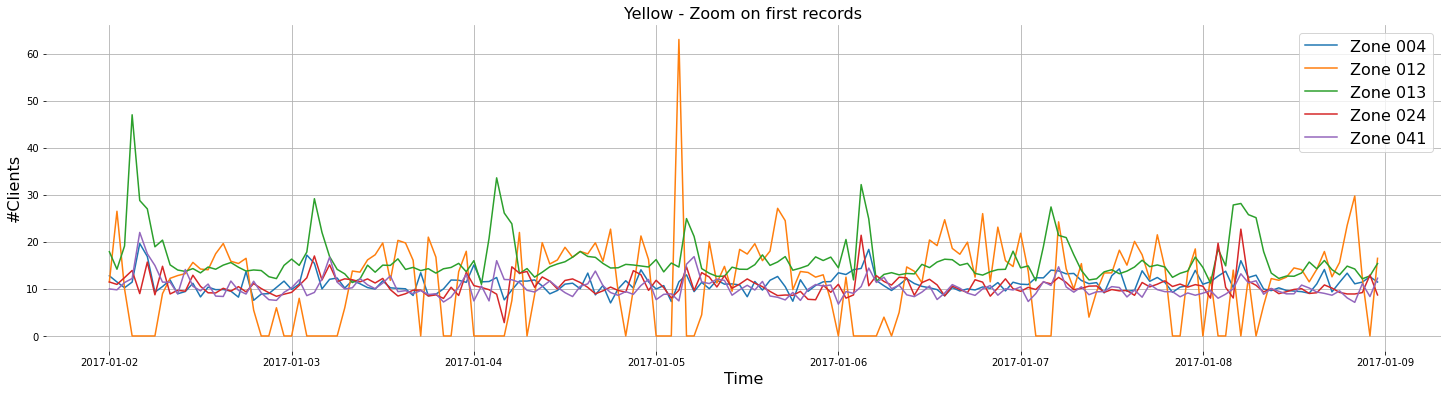

In [7]:
fig, ax = plt.subplots(figsize=FIGSIZE)

for agent_id_col in selected_zones[:5]:
    plt.plot(yellow.index[24:8*24],
            yellow['avg_fare_amount', str(agent_id_col)].values[24:8*24],
            label="Zone {:0>3}".format(agent_id_col))
    

plt.title("Yellow - Zoom on first records", fontdict=FONT)
plt.xlabel("Time", fontdict=FONT)
plt.ylabel("#Clients", fontdict=FONT)

ax.set_frame_on(False)
plt.grid(True)
plt.legend(prop={"size": FONT["size"]})
plt.show()

### 1.4. Creating `train`/`test` sets

In [8]:
start = pd.to_datetime("2017-12-04 00:00")
train = yellow['2017-01-02':start]
test = yellow[start:pd.to_datetime("2017-12-17 23:00")]

## 2. Setting up craft models

### 2.1. Connecting to craftai api

Open a link to the Craft AI API by creating a `client` based on user's token. 

If you do not have a token yet, <a href='https://beta.craft.ai/inspector'>create a project</a> and past your `Write API token` in a file named `.env` like the following:
```sh
 CRAFT_TOKEN=your-token
```

_This file should be at the root of your cloned project. You might have to rerun the `pipenv run notebook` after filling the `.env` file._

In [9]:
client = craft_ai.pandas.Client({
  "token": os.getenv('CRAFT_TOKEN')
})

### 2.2. Setting up data streams

Each taxi zone is data stream will be uploaded to a craft ai gent.
The agent `taxi_zone_007` will be fed the trip records of zone 7


#### Initiating Agents
First we create a DataFrame `agents` that will store zone ids, alongside with our agent ids and all kind of results. 

In [10]:
agents = pd.DataFrame(
    data={
        "location_id": selected_zones,
        "agent_id": ["taxi_zone_{:0>3}".format(z) for z in selected_zones]
    }
)
agents = pd.merge(agents.astype(dtype={'location_id': int}), nyc_taxi_zones, how='left', on='location_id').set_index('location_id')
agents.head()

,agent_id,borough,zone,service_zone,community_district,designation,district_population,industrial,recreational,residential,vacant
location_id,,,,,,,,,,,
4,taxi_zone_004,Manhattan,Alphabet City,Yellow_Zone,Manhattan_CD_03,Lower East Side and Chinatown,103831.154791,6.046003,2.031669,64.939393,26.982935
12,taxi_zone_012,Manhattan,Battery Park,Yellow_Zone,Manhattan_CD_01,Financial District,130217.345712,32.057380,28.154707,33.351551,6.436362
13,taxi_zone_013,Manhattan,Battery Park City,Yellow_Zone,Manhattan_CD_01,Financial District,130217.345712,32.057380,28.154707,33.351551,6.436362
24,taxi_zone_024,Manhattan,Bloomingdale,Yellow_Zone,Manhattan_CD_07,Upper West Side,103174.978364,5.821250,38.697852,38.800175,16.680723
41,taxi_zone_041,Manhattan,Central Harlem,Boro_Zone,Manhattan_CD_10,Central Harlem,88571.946738,12.476263,5.489652,66.283168,15.750917


It's now time to setup our agents' context. In this work the configuration context is shared by all agents. 

`CONFIGURATION` indicates to the API what are the inputs features and which feature(s) we want to predict.

In [11]:
# Base configuration
MAIN_CONFIGURATION = {
    "context": {
        "day_of_week": {                # feature generated by the API from the DataFrame index
            "type" : "day_of_week"
        },
        "month_of_year": {                # feature generated by the API from the DataFrame index
            "type" : "month_of_year"
        },
        "time": {                       # feature generated by the API from the DataFrame index
            "type": "time_of_day"
        },
        "timezone": {                   # timezone for trip_counter
            "type" : "timezone",        
        }
    },
    "output": ["trip_counter"],
    "learning_period": 31536000,        # 1 year: 365d * 24h * 3600s
    "operations_as_events": True,
    "tree_max_operations": 55000,
    "tree_max_depth": 10 
}

The following function `setup_agents` will create all the agents associated to the selected zones and add the operations associated.

In [12]:
def setup_agents(agent_list, df, train):
    """ Initiate Agent with the given id and 
        add the data associated with this location_id
    """
    conf = MAIN_CONFIGURATION.copy().copy()
    # Expanding agents configuration with all features present in the dataset
    conf['context'].update({
        "trip_counter": {               # taxi trips counter
            "type": "continuous"
        },
        "trip_distance": {              # average distance
            "type": "continuous"
        },
        "fare_amount": {               # average fare amount
            "type": "continuous"
        },
        "district_population": {        # total district population          
            "type": "continuous"
        },
        "vacant": {                     # percentage of vacant area in the community district
            "type": "continuous"
        },
        "recreational": {               # percentage of recreational area in the community district         
            "type": "continuous"
        },
        "industrial": {                 # percentage of industrial area in the community district          
            "type": "continuous"
        },
        "residential": {                #  percentage of residential area in the community district
            "type": "continuous"
        }
    })
    agent_ids = df[df.index.isin(agent_list)]['agent_id']
    with timer() as elapsed:
        client.delete_agents_bulk([{'id': i} for i in agent_ids])
        print('{} agents deleted in {:0.2f}s'.format(len(agent_ids), elapsed()))
    with timer() as elapsed:
        client.create_agents_bulk([{'id': i, 'configuration': conf} for i in agent_ids])
        print('{} agents created in {:0.2f}s'.format(len(agent_ids), elapsed()))
    
    with timer() as elapsed:
        agents_dfs = [
            {
                'id': "taxi_zone_{:0>3}".format(i),
                'operations': train["pu_counter"][[str(i)]]
                    .assign(timezone=train[["timezone"]])
                    .assign(trip_distance=train["avg_trip_distance"][[str(i)]])
                    .assign(fare_amount=train["avg_fare_amount"][[str(i)]])
                    .assign(industrial=df[df.index == i]['industrial'].iloc[0])
                    .assign(recreational=df[df.index == i]['recreational'].iloc[0])
                    .assign(residential=df[df.index == i]['residential'].iloc[0])
                    .assign(vacant=df[df.index == i]['vacant'].iloc[0])
                    .assign(district_population=df[df.index == i]['district_population'].iloc[0])
                    .rename(columns={str(i): 'trip_counter'}).fillna(MISSING_VALUE)
            } for i in agent_list
        ]
        print('operations posted to {} agents in {:0.2f}s'.format(len(client.add_agents_operations_bulk(agents_dfs)), elapsed()))

In [13]:
setup_agents(selected_zones, agents, train)

KeyError: 'location_id'

### 2.3. Setting up models

#### Initiate Generators
Associate generator_id to list of agent_id

In [13]:
MIN_SAMPLES_LEAF = 125
extra_contexts = {
        "district_population": {"type": "continuous"},
        "industrial": {"type": "continuous"},
        "residential": {"type": "continuous"}
    }
outputs=['trip_counter', 'trip_distance', 'fare_amount']

In [14]:
def setup_generators(group, output):
    """ Initiate Generators with the name of the group and
        associate the agents from the given property
    """
    name = '{}_o{}_m{}'.format('Manhattan' if group.name == True else group.name, output[0]+1, MIN_SAMPLES_LEAF)
    conf = copy.deepcopy(MAIN_CONFIGURATION)
    conf['filter'] = group.agent_id.tolist()
    conf['context'].update(extra_contexts)
    conf['context'].update({output[1]:{"type": "continuous"}})
    conf['output'] = [output[1]]
    conf['min_samples_per_leaf'] = MIN_SAMPLES_LEAF
    with timer() as elapsed:
        client.delete_generator(name)
        
    with timer() as elapsed:
        client.create_generator(conf, name)
        
    del conf
    return group.agent_id.tolist()

In [45]:
zones = pd.DataFrame()
districts = pd.DataFrame()
manhattan = pd.DataFrame()

for o in enumerate(outputs):
    zones = agents.groupby('agent_id').apply(lambda g: setup_generators(g, o)).to_frame('agents_list')
    districts = agents.groupby('community_district').apply(lambda g: setup_generators(g, o)).to_frame('agents_list')
    manhattan = agents.groupby(lambda x: True).apply(lambda g: setup_generators(g, o)).to_frame('agents_list')
    print('All generators created for output `{}`'.format(o[1]))

# zones = agents.groupby('agent_id').apply(lambda g: g.agent_id.tolist()).to_frame('agents_list')
# districts = agents.groupby('community_district').apply(lambda g: g.agent_id.tolist()).to_frame('agents_list')
# manhattan = agents.groupby(lambda x: True).apply(lambda g: g.agent_id.tolist()).to_frame('agents_list')

### 2.4. Retrieving decision trees

In [46]:
def get_decision_tree(group, output):
    name = '{}_o{}_m{}'.format('Manhattan' if group.name == True else group.name, output+1, MIN_SAMPLES_LEAF)
    with timer() as elapsed:
        try:
            tree = client.get_generator_decision_tree(name)
            return tree
        except Exception as err:
            print('-- /!\ Error while getting decision tree for generator `{}`:\n\t\t{} ({:0.2f}s)'.format(name, err, elapsed()))
            return dict()

In [47]:
'''
That part may take a while,

'''

generators = pd.DataFrame()
for o, _ in enumerate(outputs):
#     zones = zones.assign(dt=agents.groupby('agent_id').apply(lambda g: get_decision_tree(g, o))).rename(columns={'dt': 'decision_tree_{}'.format(o + 1)})
#     districts = districts.assign(dt=agents.groupby('community_district').apply(lambda g: get_decision_tree(g, o))).rename(columns={'dt': 'decision_tree_{}'.format(o + 1)})
    manhattan = manhattan.assign(dt=agents.groupby(lambda x: True).apply(lambda g: get_decision_tree(g, o))).rename(columns={'dt': 'decision_tree_{}'.format(o + 1)})
generators = districts.append(zones).append(manhattan.rename(index={True:'Manhattan'}))
generators.head()

-- /!\ Error while getting decision tree for generator `taxi_zone_043_o1_m125`:
		'ac7ee285-d04c-4411-9b8d-470e09ae8283 - [GeneratorContextNotFound] No context operation available for "taxi_zone_043_o1_m125".' (0.05s)
-- /!\ Error while getting decision tree for generator `taxi_zone_043_o2_m125`:
		'4a6cd7ad-8a7e-4bbf-9252-1c26dd43e2d9 - [GeneratorContextNotFound] No context operation available for "taxi_zone_043_o2_m125".' (0.06s)
-- /!\ Error while getting decision tree for generator `taxi_zone_043_o3_m125`:
		'd42768c7-5d6e-4286-bb3b-699deb16d012 - [GeneratorContextNotFound] No context operation available for "taxi_zone_043_o3_m125".' (2.75s)


,agents_list,decision_tree_1,decision_tree_2,decision_tree_3
Manhattan_CD_01,"[taxi_zone_012, taxi_zone_013, taxi_zone_087, ...","{'_version': '2.0.0', 'trees': {'trip_counter'...","{'_version': '2.0.0', 'trees': {'trip_distance...","{'_version': '2.0.0', 'trees': {'fare_amount':..."
Manhattan_CD_02,"[taxi_zone_113, taxi_zone_114, taxi_zone_125, ...","{'_version': '2.0.0', 'trees': {'trip_counter'...","{'_version': '2.0.0', 'trees': {'trip_distance...","{'_version': '2.0.0', 'trees': {'fare_amount':..."
Manhattan_CD_03,"[taxi_zone_004, taxi_zone_045, taxi_zone_079, ...","{'_version': '2.0.0', 'trees': {'trip_counter'...","{'_version': '2.0.0', 'trees': {'trip_distance...","{'_version': '2.0.0', 'trees': {'fare_amount':..."
Manhattan_CD_04,"[taxi_zone_048, taxi_zone_050, taxi_zone_068, ...","{'_version': '2.0.0', 'trees': {'trip_counter'...","{'_version': '2.0.0', 'trees': {'trip_distance...","{'_version': '2.0.0', 'trees': {'fare_amount':..."
Manhattan_CD_05,"[taxi_zone_100, taxi_zone_161, taxi_zone_163, ...","{'_version': '2.0.0', 'trees': {'trip_counter'...","{'_version': '2.0.0', 'trees': {'trip_distance...","{'_version': '2.0.0', 'trees': {'fare_amount':..."


## 4. Decision time!

Now that we have retrieved our models, we are able to predict the best place to find clients.

### 4.1. Decision Dataframe setup

First we setup the `DECISION_DF` where the prediction inputs are located. In this work `DECISION_DF` is quite simple: it's just an index with the `timezone` column. Indeed, columns `day_of_week` and `time` are computed by the API from the index.

To evaluate the predictions we are testing our agents on the `test` set. So we are testing our agents on the last year of the year 2017.

In [60]:
# DECISION_DF is the same basis for all taxi zones. We will enrich it later on with specific characteristics for each zone.
TEST_DF = pd.DataFrame(index=test.index)
TEST_DF['timezone'] = TEST_DF.index.strftime('%z')

### 4.2. Take Decisions

Ask each Agent to estimate the taxi need for their own `taxi_zone` thanks to the `DECISION_DF`.

In [49]:
def decide(agent, output):
    tree = generators.loc['Manhattan','decision_tree_{}'.format(output[0] + 1)]
    test_df = TEST_DF.copy()
    for ctx in extra_contexts.keys():
        test_df[ctx] = agent[ctx]
    try:
        decision = client.decide_from_contexts_df(tree, test_df.fillna(MISSING_VALUE))
        return pd.Series({ c: decision[c].values for c in decision.columns })
    except:
        return pd.Series()

In [141]:
decisions_df = pd.DataFrame(index=agents.index)
for o in enumerate(outputs):
    decisions_df = decisions_df.join(agents.apply(lambda agent: decide(agent, o), axis=1))
decisions_df.head(2)

,trip_counter_confidence,trip_counter_decision_path,trip_counter_decision_rules,trip_counter_max,trip_counter_min,trip_counter_nb_samples,trip_counter_predicted_value,trip_counter_standard_deviation,trip_distance_confidence,trip_distance_decision_path,...,trip_distance_predicted_value,trip_distance_standard_deviation,fare_amount_confidence,fare_amount_decision_path,fare_amount_decision_rules,fare_amount_max,fare_amount_min,fare_amount_nb_samples,fare_amount_predicted_value,fare_amount_standard_deviation
location_id,,,,,,,,,,,,,,,,,,,,,
4,"[0.5092403888702393, 0.4574141502380371, 0.464...","[0-0-0-0-0-0-0-0-0, 0-0-0-0-0-0-1-1-0-1-0, 0-0...","[[{'property': 'residential', 'operator': '<',...","[248, 537, 423, 423, 423, 423, 248, 335, 335, ...","[0, 1, 0, 0, 0, 0, 2, 8, 8, 8, 8, 8, 8, 8, 8, ...","[130, 276, 1104, 1104, 1104, 1104, 253, 240, 2...","[60.892292, 85.42028, 44.0616, 44.0616, 44.061...","[57.769684, 100.65159, 50.632553, 50.632553, 5...","[0.8325746059417725, 0.8325746059417725, 0.727...","[0-1-0-1-0-1-0-0-1, 0-1-0-1-0-1-0-0-1, 0-1-0-1...",...,"[3.2589715, 3.2589715, 3.3562627, 3.4303675, 4...","[0.633732, 0.633732, 1.2320518, 2.4372518, 3.5...","[0.8848110437393188, 0.828671395778656, 0.8286...","[0-0-1-1-0-1-0-0-1-0, 0-0-1-1-0-1-0-0-1-1, 0-0...","[[{'property': 'district_population', 'operato...","[18.833334, 40.0, 40.0, 40.0, 38.0, 31.833334,...","[8.4, 0.0, 0.0, 0.0, 3.0, 0.0, 6.8333335, 7.53...","[235, 355, 355, 355, 171, 342, 160, 377, 377, ...","[12.737668, 12.414226, 12.414226, 12.414226, 1...","[1.597251, 2.524571, 2.524571, 2.524571, 4.921..."
12,"[0.45616456866264343, 0.4601144790649414, 0.44...","[0-0-1-1-0-0-0-0, 0-0-1-1-0-0-1-0-0-0, 0-0-1-1...","[[{'property': 'residential', 'operator': '<',...","[87, 82, 49, 49, 49, 40, 112, 244, 306, 233, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[156, 264, 828, 828, 828, 276, 396, 216, 207, ...","[15.29487, 10.863634, 4.8478255, 4.8478255, 4....","[18.020853, 12.65799, 5.98414, 5.98414, 5.9841...","[0.5213279128074646, 0.5213279128074646, 0.521...","[0-1-0-1-0-0-1-0-0-1, 0-1-0-1-0-0-1-0-0-1, 0-1...",...,"[2.671111, 2.671111, 2.671111, 3.4303675, 4.06...","[2.4443195, 2.4443195, 2.4443195, 2.4372518, 3...","[0.5367650389671326, 0.5217244029045105, 0.506...","[0-0-1-0-1-0-1-0-0-1, 0-0-1-0-1-0-1-1-0-0, 0-0...","[[{'property': 'district_population', 'operato...","[32.0, 60.0, 35.5, 52.0, 60.5, 56.5, 52.0, 52....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[162, 198, 207, 297, 288, 272, 405, 405, 405, ...","[9.789891, 9.709962, 8.812587, 10.5352955, 12....","[8.336906, 8.807798, 8.503547, 10.662867, 12.9..."


Each decision is explainable. You can analyse the tree directly in your <a href="https://beta.craft.ai/inspector/">project's inspector</a>, or your can print the decision rule that has led to the decision.

In [133]:
# decision to explain:
zone_id_to_explain = 90
decision_idx_to_explain = 1

line_to_explain = decisions_df[decisions_df.index == zone_id_to_explain]

decision =  line_to_explain.trip_counter_predicted_value.values[0][decision_idx_to_explain]
        
rule_to_explain = line_to_explain.trip_counter_decision_rules.values[0][decision_idx_to_explain]

print('Generator {0} has predicted {1:0.0f} clients in his zone,\nbecause '
      .format(zone_id_to_explain, decision),
      craft_ai.format_decision_rules(
          craft_ai.reduce_decision_rules(rule_to_explain)
      ))

Generator 90 has predicted 62 clients in his zone,
because  'residential' < 77.66176 and 'industrial' < 4.6847725 and 'time' in [1, 6[ and 'day_of_week' in [0, 3[


### 4.3. Observe results

In [52]:
# To display without timezone shifting
utc_test_index = pd.date_range('2017-12-04 00:00', 
                        "2017-12-17 23:00", freq="h") 

Reformat results:

In [134]:
trip_counter_prediction = decisions_df.trip_counter_predicted_value.apply(lambda v: pd.Series(v, dtype=float)).T.set_index(DECISION_DF.index)
trip_distance_prediction = decisions_df.trip_distance_predicted_value.apply(lambda v: pd.Series(v, dtype=float)).T.set_index(DECISION_DF.index)
fare_amount_prediction = decisions_df.fare_amount_predicted_value.apply(lambda v: pd.Series(v, dtype=float)).T.set_index(DECISION_DF.index)

trip_counter_prediction.head(2)

location_id,4,12,13,24,41,42,43,45,48,50,...,237,238,239,243,244,246,249,261,262,263
pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2017-12-04 00:00:00-05:00,60.892292,15.294870,15.294870,60.892292,15.631012,15.631012,171.847804,60.892292,60.892292,60.892292,...,92.824905,60.892292,60.892292,1.628205,1.628205,60.892292,109.84210,15.294870,92.824905,92.824905
2017-12-04 01:00:00-05:00,85.420280,10.863634,10.863634,20.163038,15.631012,15.631012,171.847804,85.420280,62.305714,62.305714,...,35.913044,20.163038,20.163038,0.661905,0.661905,62.305714,70.24306,10.863634,35.913044,35.913044


In [135]:
trip_counter_std = decisions_df.trip_counter_standard_deviation.apply(lambda v: pd.Series(v, dtype=float)).T.set_index(DECISION_DF.index)
trip_distance_std = decisions_df.trip_distance_standard_deviation.apply(lambda v: pd.Series(v, dtype=float)).T.set_index(DECISION_DF.index)
fare_amount_std = decisions_df.fare_amount_standard_deviation.apply(lambda v: pd.Series(v, dtype=float)).T.set_index(DECISION_DF.index)

trip_counter_std.head(2)

location_id,4,12,13,24,41,42,43,45,48,50,...,237,238,239,243,244,246,249,261,262,263
pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2017-12-04 00:00:00-05:00,57.769684,18.020853,18.020853,57.769684,11.258964,11.258964,213.332725,57.769684,57.769684,57.769684,...,84.037250,57.769684,57.769684,2.645063,2.645063,57.769684,72.336420,18.020853,84.037250,84.037250
2017-12-04 01:00:00-05:00,100.651590,12.657990,12.657990,18.216743,11.258964,11.258964,213.332725,100.651590,53.498207,53.498207,...,30.259584,18.216743,18.216743,1.444263,1.444263,53.498207,53.367474,12.657990,30.259584,30.259584


Static visualization:

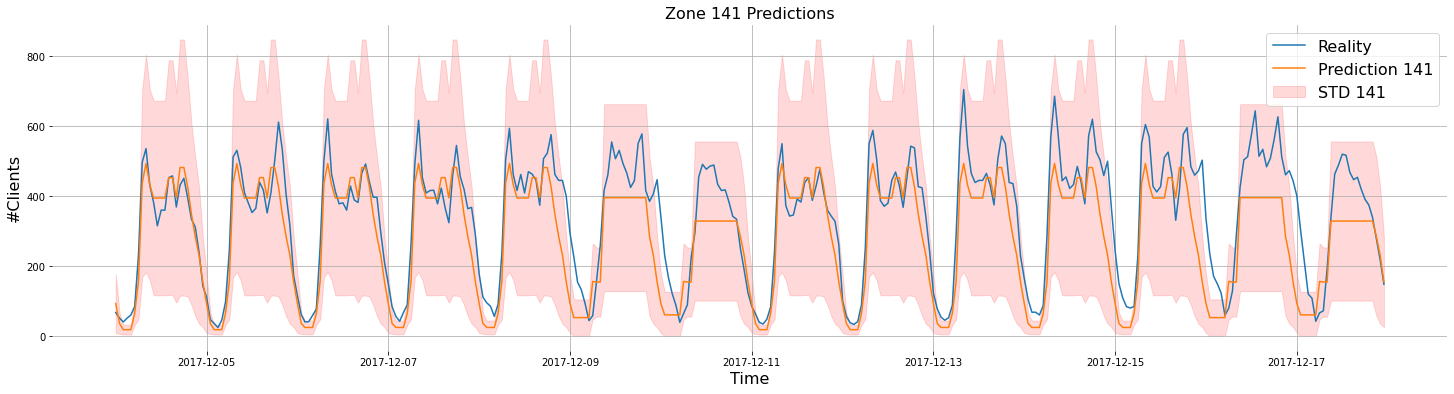

In [139]:
zone = 141

fig, ax = plt.subplots(figsize=FIGSIZE)

plt.plot(utc_test_index, test['pu_counter'][str(zone)], label='Reality')
plt.plot(utc_test_index, trip_counter_prediction[zone],
            label='Prediction {:0>3}'.format(zone))

ax.fill_between(utc_test_index, 
                trip_counter_prediction[zone] + trip_counter_std[zone], 
                (trip_counter_prediction[zone] - trip_counter_std[zone]).clip(0), 
                color='red', alpha=0.15, 
                label='STD {:0>3}'.format(zone))

plt.title('Zone {:0>3} Predictions'.format(zone), fontdict=FONT)
plt.xlabel('Time', fontdict=FONT)
plt.ylabel('#Clients', fontdict=FONT)

ax.set_frame_on(False)
plt.grid(True)
plt.legend(prop={'size': FONT['size']})
plt.show()

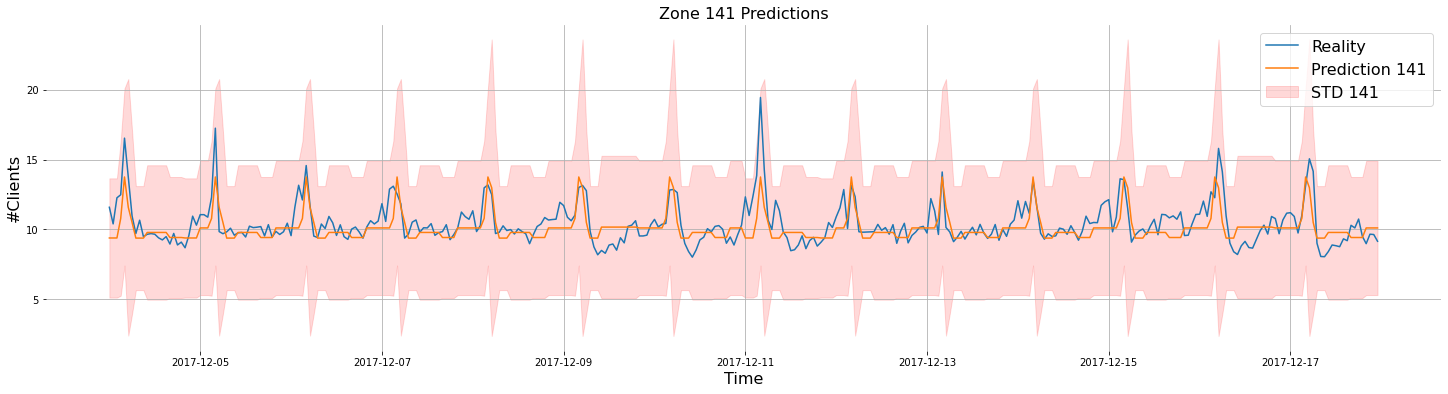

In [140]:
fig, ax = plt.subplots(figsize=FIGSIZE)

plt.plot(utc_test_index, test['avg_fare_amount'][str(zone)], label='Reality')
plt.plot(utc_test_index, fare_amount_prediction[zone],
            label='Prediction {:0>3}'.format(zone))

ax.fill_between(utc_test_index, 
                fare_amount_prediction[zone] + fare_amount_std[zone], 
                (fare_amount_prediction[zone] - fare_amount_std[zone]).clip(0), 
                color='red', alpha=0.15, 
                label='STD {:0>3}'.format(zone))

plt.title('Zone {:0>3} Predictions'.format(zone), fontdict=FONT)
plt.xlabel('Time', fontdict=FONT)
plt.ylabel('#Clients', fontdict=FONT)

ax.set_frame_on(False)
plt.grid(True)
plt.legend(prop={'size': FONT['size']})
plt.show()

To have a deeper analysis, please refer to `Benchmarks.ipynb`.

```python
#save results for benchmark analysis:
predictions.to_csv(PATH + 'craftai.csv')
stds.to_csv(PATH + 'craftai_std.csv')

```

## 5. Conclusion: Evaluate Best Taxi Zone 

Based on all Agents estimations, find the `taxi_zone` with the most persons looking for a taxi. 

In [185]:
def best_zone(row):
    return agents.index.values[np.argmax(row.values)]

In [197]:
trip_counter_prediction['best_zone'] = trip_counter_prediction[[int(z) for z in selected_zones_str]].apply(best_zone, axis=1)

trip_counter_prediction[trip_counter_prediction['best_zone']==trip_counter_prediction['best_zone'].max()].head()

location_id,4,12,13,24,41,42,43,45,48,50,...,238,239,243,244,246,249,261,262,263,best_zone
pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2017-12-04 07:00:00-05:00,74.7500,41.319435,41.319435,216.18750,46.02063,46.02063,171.847804,74.7500,260.93835,260.93835,...,216.18750,216.18750,4.358587,4.358587,260.93835,96.99616,41.319435,437.48810,437.48810,140
2017-12-04 08:00:00-05:00,74.7500,56.067646,56.067646,285.44846,46.02063,46.02063,171.847804,74.7500,260.93835,260.93835,...,285.44846,285.44846,4.358587,4.358587,260.93835,165.27780,56.067646,493.52362,493.52362,140
2017-12-05 07:00:00-05:00,82.4953,41.319435,41.319435,216.18750,46.02063,46.02063,171.847804,82.4953,260.93835,260.93835,...,216.18750,216.18750,4.358587,4.358587,260.93835,96.99616,41.319435,437.48810,437.48810,140
2017-12-05 08:00:00-05:00,82.4953,56.067646,56.067646,285.44846,46.02063,46.02063,171.847804,82.4953,260.93835,260.93835,...,285.44846,285.44846,4.358587,4.358587,260.93835,165.27780,56.067646,493.52362,493.52362,140
2017-12-06 07:00:00-05:00,82.4953,41.319435,41.319435,216.18750,46.02063,46.02063,171.847804,82.4953,260.93835,260.93835,...,216.18750,216.18750,4.358587,4.358587,260.93835,96.99616,41.319435,437.48810,437.48810,140


Let's have a look to the results:

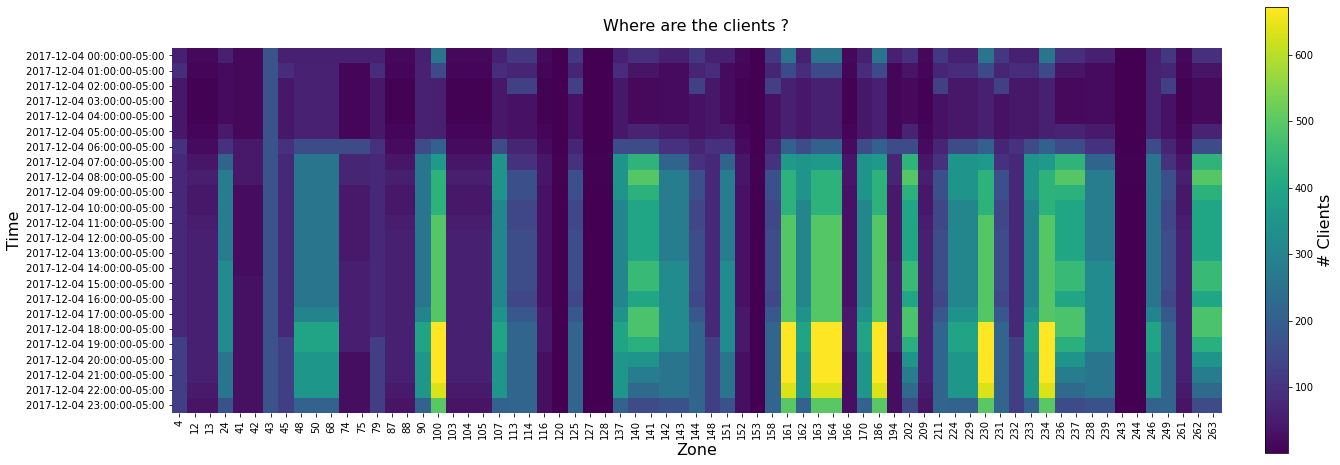

In [211]:
def plot_matshow(matrix, text, categories=None ):
    """
    Plots a graphical representation of a given matrix
    """
    
    FIGSIZE = (20, 20)
    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.set_frame_on(False)
    
    if categories :
        cax = ax.matshow(matrix, cmap=plt.cm.get_cmap('viridis', len(categories)))        

        # We must be sure to specify the ticks matching our target names
        step = (max(categories))/len(categories)
        locs = [step*(i + 1/2) for i in range(len(categories))]
        
        cbar = fig.colorbar(cax, ticks=locs, fraction=0.046, pad=0.04)
        cbar.ax.set_yticklabels(['Zone {:0>3}'.format(c) for c in categories])

    else:
        cax = ax.matshow(matrix)

        cbar = fig.colorbar(cax, fraction=0.020, pad=0.04)
        cbar.ax.set_ylabel(text['cbar_label'], rotation=90, fontdict=FONT)

    plt.tick_params(
    axis='x',       
    which='both',   
    bottom=True,      
    top=False,  
    labeltop=False,
    labelbottom=True)
    
    x_tick_labels = text['x_tick_labels']
    y_tick_labels = text['y_tick_labels']
    
    plt.xticks(range(len(x_tick_labels)), x_tick_labels, rotation='vertical')
    plt.yticks(range(len(y_tick_labels)), y_tick_labels)
    
    plt.title(text['title'], fontdict=FONT, y=1.03)
    plt.xlabel(text['xlabel'], fontdict=FONT)
    plt.ylabel(text['ylabel'], fontdict=FONT)
    
    plt.show()
    
nb_hours_to_display = 24 # display the first day

plot_text = {
    'x_tick_labels': selected_zones,
    'y_tick_labels': trip_counter_prediction.index[:nb_hours_to_display],
    'title': 'Where are the clients ?',
    'xlabel': 'Zone',
    'ylabel': 'Time',
    'cbar_label': '# Clients'
}

plot_matshow(trip_counter_prediction[[int(z) for z in selected_zones_str]][:nb_hours_to_display], plot_text)

Thanks for reading this notebook until the end! 

 * If you want to work on more data you can check `Preprocessing.ipynb`.
 * To see the benchmarks it's with `Benchmarks.ipynb`.